In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import os

In [ ]:
import pickle

In [ ]:
DATA_FILE = os.path.join('../data', 'train.csv')

In [ ]:
data = pd.read_csv(DATA_FILE, parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [ ]:
data.iloc[0:5]

In [ ]:
data.columns

In [ ]:
data['pickup_hr'] = data['pickup_datetime'].dt.hour
data['pickup_min'] = data['pickup_datetime'].dt.minute
data['pickup_sec'] = data['pickup_datetime'].dt.second
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data['pickup_date'] = data['pickup_datetime'].dt.day
data['pickup_mon'] = data['pickup_datetime'].dt.month
data['pickup_yr'] = data['pickup_datetime'].dt.year

In [ ]:
data = data.assign(pickup_longitude=lambda df: np.round(df.pickup_longitude, 4))
data = data.assign(pickup_latitude=lambda df: np.round(df.pickup_latitude, 4))
data = data.assign(dropoff_longitude=lambda df: np.round(df.dropoff_longitude, 4))
data = data.assign(dropoff_latitude=lambda df: np.round(df.dropoff_latitude, 4))

In [ ]:
data = data.assign(st_dist=lambda df: np.sqrt((df.pickup_longitude-df.dropoff_longitude)**2 + 
                                       (df.pickup_latitude-df.dropoff_latitude)**2))

In [ ]:
data.columns

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(data['pickup_longitude'], data['pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['dropoff_longitude'], data['dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [ ]:
data['s_pickup_latitude'] = (data['pickup_latitude'] - data['pickup_latitude'].min())/(data['pickup_latitude'].max() - data['pickup_latitude'].min())
data['s_pickup_longitude'] = (data['pickup_longitude'] - data['pickup_longitude'].min())/(data['pickup_longitude'].max() - data['pickup_longitude'].min())

data['s_dropoff_latitude'] = (data['dropoff_latitude'] - data['dropoff_latitude'].min())/(data['dropoff_latitude'].max() - data['dropoff_latitude'].min())
data['s_dropoff_longitude'] = (data['dropoff_longitude'] - data['dropoff_longitude'].min())/(data['dropoff_longitude'].max() - data['dropoff_longitude'].min())

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(data['s_pickup_longitude'], data['s_pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['s_dropoff_longitude'], data['s_dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [ ]:
data['flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)

In [ ]:
data['month_end'] = (data['pickup_datetime'].dt.is_month_end).astype(int)
data['month_start'] = (data['pickup_datetime'].dt.is_month_start).astype(int)

In [ ]:
data['month_start'].hist()

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(data['trip_duration'][:1000], data['month_end'][:1000], 'r.')

plt.subplot(2, 1, 2)
plt.plot(data['trip_duration'][:1000], data['month_start'][:1000], 'b.')

plt.show()

In [ ]:
data['flag'].hist()

In [ ]:
data['pickup_yr'].hist()

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime

In [ ]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2015, 12, 31), end=datetime(2017, 1, 1))

data['holiday'] = (data['pickup_datetime'].dt.date.astype('datetime64[ns]').isin(holidays)).astype(int)

In [ ]:
data['holiday'].hist()

In [ ]:
from haversine import haversine

def haversine_dist(pos):
    p1 = (pos[0], pos[1])
    p2 = (pos[2], pos[1])
    p3 = (pos[2], pos[3])
    dist = haversine(p1, p2) + haversine(p2, p3)
    return dist

def bearing(pos):
    lat1 = np.radians(pos[0])
    lat2 = np.radians(pos[2])
    
    diffLong = np.radians(pos[1] - pos[3])
    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
positions = data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
data['h_dist'] = map(lambda p: haversine_dist(p), positions.as_matrix())
data['bearing'] = map(lambda p: bearing(p), positions.as_matrix())

In [ ]:
data['h_dist'].hist(bins=50)

In [ ]:
from matplotlib import pyplot as plt

plt.hist(data['h_dist'], bins=50, normed=True, range=(-0.001, 0.04))
plt.hist(data['h_dist'], bins=50, normed=True, range=(0.04, 1))
plt.hist(data['h_dist'], bins=50, normed=True, range=(1, 1.4))
plt.show()

In [ ]:
df1 = data[['pickup_longitude', 'pickup_latitude']].as_matrix()
df2 = data[['dropoff_longitude', 'dropoff_latitude']].as_matrix()
features = np.round(np.vstack([df1, df2]), 5)

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [133]:
cluster = MiniBatchKMeans(n_clusters=16, max_iter=1000, batch_size=100000, verbose=0, compute_labels=True, 
                          random_state=None, tol=0.0, max_no_improvement=10, n_init=3, reassignment_ratio=0.005)

In [134]:
cluster.fit(features)

MiniBatchKMeans(batch_size=100000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=1000, max_no_improvement=10,
        n_clusters=16, n_init=3, random_state=None,
        reassignment_ratio=0.005, tol=0.0, verbose=0)

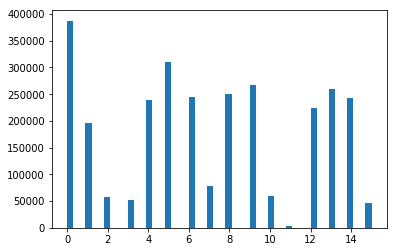

In [135]:
_ = plt.hist(cluster.labels_, bins=50)
plt.show()

In [ ]:
data['pickup_cluster_label'] = cluster.predict(data[['pickup_longitude', 'pickup_latitude']])
data['dropoff_cluster_label'] = cluster.predict(data[['dropoff_longitude', 'dropoff_latitude']])

In [ ]:
idx = data['pickup_cluster_label'].as_matrix()
data['pickup_cluster_longitude'] = cluster.cluster_centers_[idx][:, 0]
data['pickup_cluster_latitude'] = cluster.cluster_centers_[idx][:, 1]

idx = data['dropoff_cluster_label'].as_matrix()
data['dropoff_cluster_longitude'] = cluster.cluster_centers_[idx][:, 0]
data['dropoff_cluster_latitude'] = cluster.cluster_centers_[idx][:, 1]

In [ ]:
positions = data[['pickup_cluster_latitude', 'pickup_cluster_longitude', 
                  'dropoff_cluster_latitude', 'dropoff_cluster_longitude']]
data['cluster_dist'] = map(lambda p: haversine_dist(p), positions.as_matrix())

In [ ]:
_ = plt.hist(np.log(data['cluster_dist'] + 1.0), bins=25, normed=1)
plt.show()

In [ ]:
_ = plt.hist(np.log(data['h_dist'] + 1.0), bins=50, normed=1)
plt.show()

In [ ]:
pickle.dump(cluster, open( "cluster.p", "wb" ))

In [106]:
cols = ['id', 'pickup_mon', 'pickup_date', 'pickup_hr', 'dropoff_cluster_label']
grp = data[cols].groupby(['pickup_mon', 'pickup_date', 'pickup_hr', 
                          'dropoff_cluster_label']).agg('count')

In [107]:
grp.columns = [x+'_count' for x in grp.columns]

In [108]:
grp.head()

id_count
pickup_mon pickup_date pickup_hr dropoff_cluster_label          
1          1           0         0                            51
                                 1                            10
                                 2                            92
                                 4                            72
                                 5                             1

In [109]:
grp.reset_index(inplace=True)

In [110]:
grp.head()

,pickup_mon,pickup_date,pickup_hr,dropoff_cluster_label,id_count
0,1,1,0,0,51
1,1,1,0,1,10
2,1,1,0,2,92
3,1,1,0,4,72
4,1,1,0,5,1


In [111]:
df1 = data.merge(grp, how='inner', left_on=['pickup_mon', 'pickup_date', 'pickup_hr', 
                          'dropoff_cluster_label'], 
               right_on=['pickup_mon', 'pickup_date', 'pickup_hr', 
                          'dropoff_cluster_label'])

In [112]:
df1.head()

,pickup_mon,pickup_date,pickup_hr,dropoff_cluster_label,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,...,holiday,h_dist,bearing,pickup_cluster_label,pickup_cluster_longitude,pickup_cluster_latitude,dropoff_cluster_longitude,dropoff_cluster_latitude,cluster_dist,id_count
0,3,14,17,2,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.9822,...,0,1.737978,260.215987,13,-73.976256,40.761730,-73.954914,40.771838,2.921161,69
1,3,14,17,2,id1889642,1,2016-03-14 17:14:56,2016-03-14 17:40:58,2,-74.0035,...,0,7.972216,315.410436,0,-73.996571,40.741483,-73.954914,40.771838,6.883255,69
2,3,14,17,2,id0415243,1,2016-03-14 17:03:38,2016-03-14 17:28:19,1,-73.9564,...,0,5.893903,183.560777,4,-73.962772,40.794608,-73.954914,40.771838,3.193716,69
3,3,14,17,2,id2988205,2,2016-03-14 17:51:49,2016-03-14 18:15:38,1,-73.9917,...,0,3.682273,304.542737,7,-73.988690,40.754055,-73.954914,40.771838,4.821645,69
4,3,14,17,2,id1654195,1,2016-03-14 17:19:33,2016-03-14 17:33:51,1,-73.9601,...,0,1.521650,4.432788,2,-73.954914,40.771838,-73.954914,40.771838,0.000000,69


In [113]:
cols = ['id', 'pickup_mon', 'pickup_date', 'pickup_hr']
grp = data[cols].groupby(['pickup_mon', 'pickup_date', 'pickup_hr']).agg('count')
grp.columns = [x+'_count_hr' for x in grp.columns]
grp.reset_index(inplace=True)

In [114]:
grp.head()

,pickup_mon,pickup_date,pickup_hr,id_count_hr
0,1,1,0,546
1,1,1,1,566
2,1,1,2,503
3,1,1,3,479
4,1,1,4,323


In [115]:
df1 = df1.merge(grp, how='inner', left_on=['pickup_mon', 'pickup_date', 'pickup_hr'], 
               right_on=['pickup_mon', 'pickup_date', 'pickup_hr'])

In [116]:
df1.head()

,pickup_mon,pickup_date,pickup_hr,dropoff_cluster_label,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,...,h_dist,bearing,pickup_cluster_label,pickup_cluster_longitude,pickup_cluster_latitude,dropoff_cluster_longitude,dropoff_cluster_latitude,cluster_dist,id_count,id_count_hr
0,3,14,17,2,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.9822,...,1.737978,260.215987,13,-73.976256,40.761730,-73.954914,40.771838,2.921161,69,423
1,3,14,17,2,id1889642,1,2016-03-14 17:14:56,2016-03-14 17:40:58,2,-74.0035,...,7.972216,315.410436,0,-73.996571,40.741483,-73.954914,40.771838,6.883255,69,423
2,3,14,17,2,id0415243,1,2016-03-14 17:03:38,2016-03-14 17:28:19,1,-73.9564,...,5.893903,183.560777,4,-73.962772,40.794608,-73.954914,40.771838,3.193716,69,423
3,3,14,17,2,id2988205,2,2016-03-14 17:51:49,2016-03-14 18:15:38,1,-73.9917,...,3.682273,304.542737,7,-73.988690,40.754055,-73.954914,40.771838,4.821645,69,423
4,3,14,17,2,id1654195,1,2016-03-14 17:19:33,2016-03-14 17:33:51,1,-73.9601,...,1.521650,4.432788,2,-73.954914,40.771838,-73.954914,40.771838,0.000000,69,423


In [119]:
df1['traffic_hr_cluster'] = df1['id_count']/df1['id_count_hr']*1.0

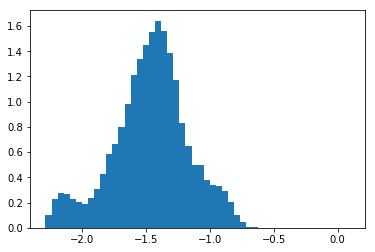

In [131]:
_ = plt.hist(np.log(df1['traffic_hr_cluster']+0.1), bins=50, normed=True)
plt.show()

In [132]:
df1.columns

Index([u'pickup_mon', u'pickup_date', u'pickup_hr', u'dropoff_cluster_label',
       u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_min', u'pickup_sec', u'pickup_day',
       u'pickup_yr', u'st_dist', u's_pickup_latitude', u's_pickup_longitude',
       u's_dropoff_latitude', u's_dropoff_longitude', u'flag', u'month_end',
       u'month_start', u'holiday', u'h_dist', u'bearing',
       u'pickup_cluster_label', u'pickup_cluster_longitude',
       u'pickup_cluster_latitude', u'dropoff_cluster_longitude',
       u'dropoff_cluster_latitude', u'cluster_dist', u'id_count',
       u'id_count_hr', u'traffic_hr_cluster'],
      dtype='object')